In [1]:
#### import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping

import wandb
import numpy as np
import matplotlib.pyplot as plt

AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 128 if AVAIL_GPUS else 32

NameError: name 'torch' is not defined

In [2]:
pl.seed_everything(125)

Global seed set to 125


125

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## 1. Data Description

In [4]:
scale_noise = 0.2
range_x = [-2, 2]

arr_x = torch.linspace(range_x[0], range_x[1], 1000)
arr_y = arr_x + torch.sin(arr_x * torch.pi)
arr_y_noise = arr_y + torch.randn((1000,)) * scale_noise

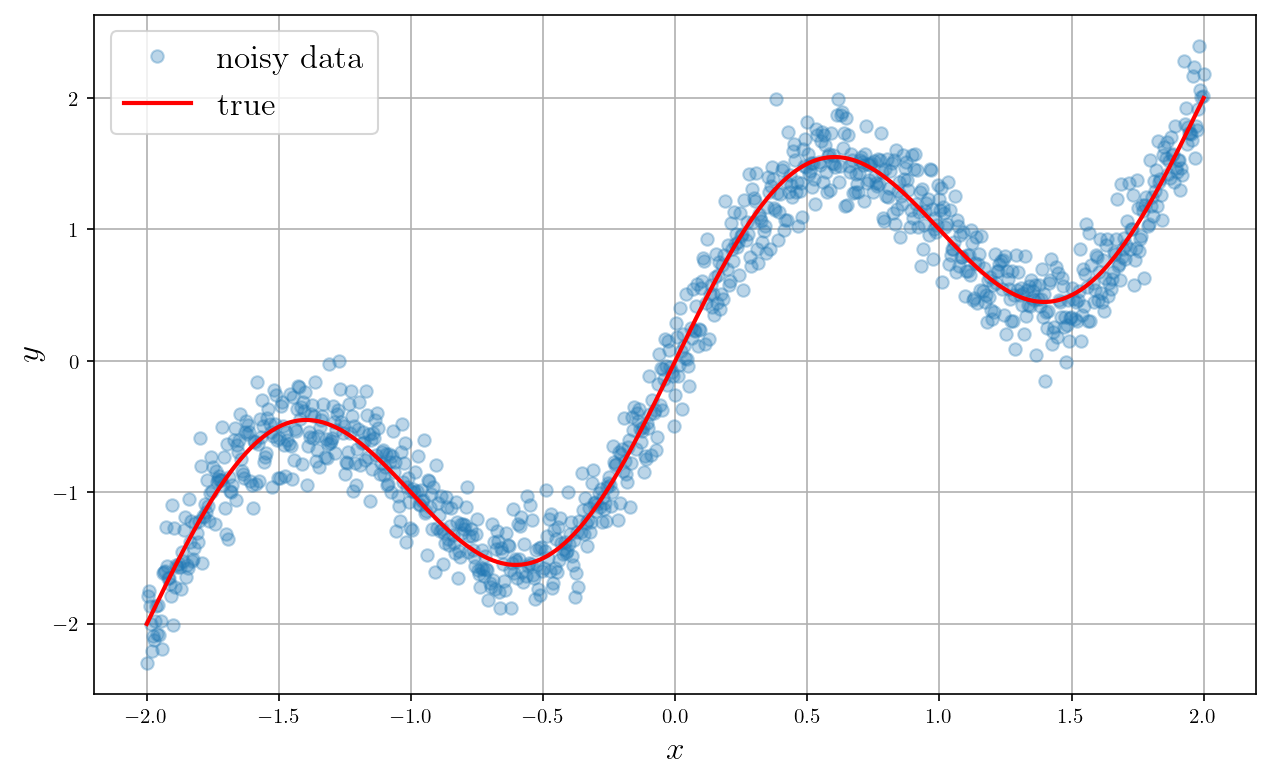

In [5]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(arr_x, arr_y_noise, 'o', label='noisy data', alpha=0.3)
plt.plot(arr_x, arr_y, 'r-', linewidth=2,label='true')
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.show()

## 2. Make Dataset

In [6]:
class NoisyData(Dataset):
    def __init__(self, x, y, y_true):
        self.x = x.reshape((-1,1))
        self.y = y.reshape((-1,1))
        self.y_true = y_true.reshape((-1,1))
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.y_true[idx]

In [7]:
def gen_noisy_data(n, scale_noise=0.2, range_x=[-2,2]):
    arr_x = torch.linspace(range_x[0], range_x[1], n)
    arr_y = arr_x + torch.sin(arr_x * torch.pi)
    arr_y_noise = arr_y + torch.randn((n,)) * scale_noise
    return NoisyData(arr_x, arr_y_noise, arr_y)

## 3. MLP 1

### 3.1. Define Model

In [8]:
class NoisyNet(pl.LightningModule):
    def __init__(self, N=10000, hparams=None):
        super().__init__()
        
        self.N = N
        
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 1)
        )
        
        self.learning_rate = hparams['learning_rate']
        self.batch_size = hparams['batch_size']
        self.epochs = hparams['epochs']
        
        self.save_hyperparameters(hparams)
    
    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch, batch_idx):
        X, y, _ = batch
        y_hat = self(X)
        
        loss = F.mse_loss(y, y_hat)
        
        self.log('train_loss', loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y, _ = batch
        y_hat = self(X)
        
        loss = F.mse_loss(y, y_hat)
        
        self.log('val_loss', loss)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def prepare_data(self):
        self.ds = gen_noisy_data(self.N)
        self.ds2 = gen_noisy_data(self.N)
        
    def setup(self, stage=None):
        N_train = self.N // 10 * 7
        N_val = self.N - N_train
        if stage == "fit" or stage is None:
            self.ds_train, self.ds_val = random_split(self.ds, [N_train, N_val])
        if stage == "test" or stage is None:
            _, self.ds_test = random_split(self.ds2, [N_train, N_val])
            
    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.batch_size)

In [9]:
hparams = {
    "learning_rate": 1e-3,
    "batch_size": BATCH_SIZE,
    "epochs": 10000
}

model = NoisyNet(
    hparams=hparams
)

wandb_logger = WandbLogger(
    project='MLP2Autoregressive'
)

trainer = Trainer(
    logger=wandb_logger,
    max_epochs=hparams['epochs'],
    gpus=AVAIL_GPUS,
    enable_progress_bar=False,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=50, mode='min')
    ]
    
)

wandb: Currently logged in as: axect (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### 3.2. Train

In [10]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 2.2 K 
------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)
/home/xteca/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/xteca/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which i

In [11]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▆▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,152
train_loss,0.03831
trainer/global_step,8414
val_loss,0.0407


In [12]:
best_model = NoisyNet.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
best_model.eval()

NoisyNet(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=16, out_features=1, bias=True)
  )
)

### 3.3. Test

In [13]:
test_data = gen_noisy_data(1000)
x = test_data.x
y = test_data.y
y_true = test_data.y_true
y_hat = best_model(x).detach().cpu().numpy()

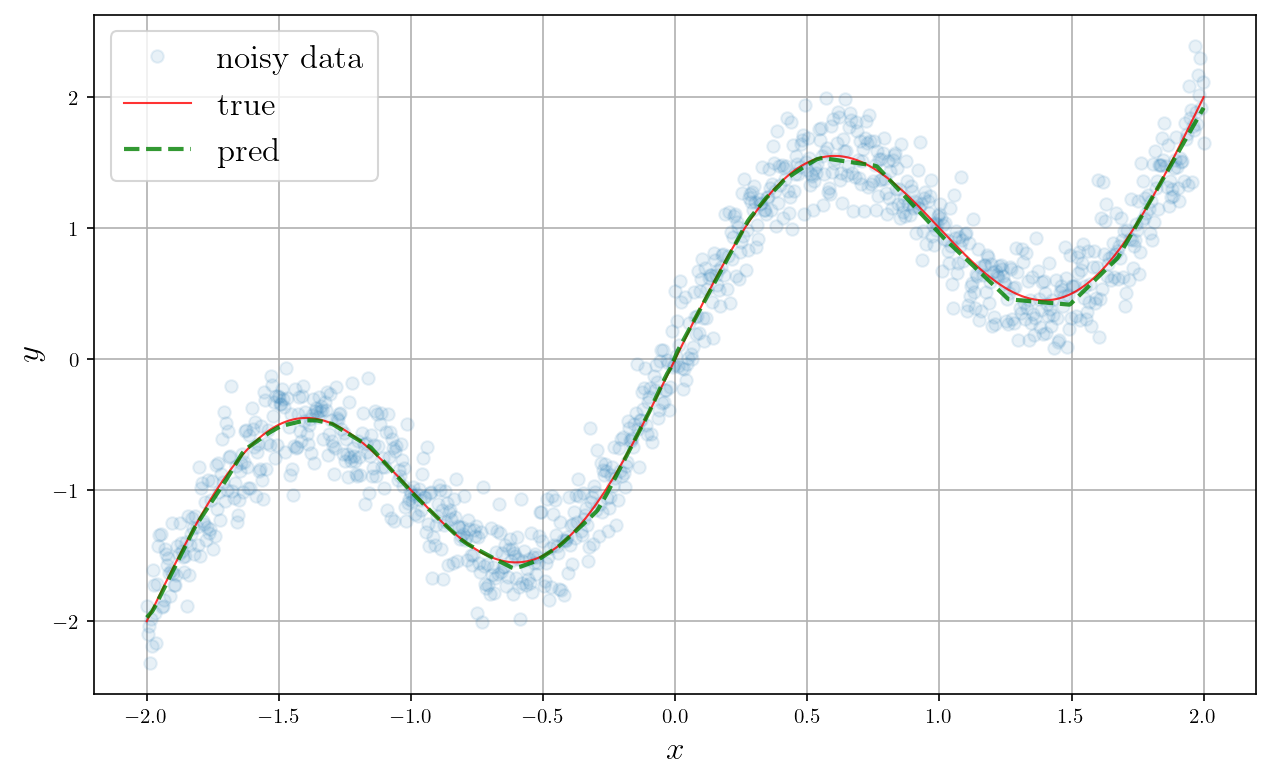

In [14]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x, y, 'o', label='noisy data', alpha=0.1)
plt.plot(x, y_true, 'r-', linewidth=1, label='true', alpha=0.8)
plt.plot(x, y_hat, 'g--', linewidth=2, label='pred', alpha=0.8)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.show()

## 4. Auto regressive Data

In [15]:
def sliding_window(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length - 1):
        _x = data[i:i+seq_length].tolist()
        _y = data[i+seq_length].tolist()
        x.append(_x)
        y.append(_y)
    return torch.tensor(x), torch.tensor(y)

In [16]:
class AutoRegData(Dataset):
    def __init__(self, x, y):
        X = torch.column_stack([x, y])
        X, y = sliding_window(X, 10)
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
def restore_from_noisy(x, model):
    x_restore = x.reshape((-1,))
    y_restore = model(x).reshape((-1,))
    return x_restore, y_restore

In [32]:
ds_noisy = gen_noisy_data(3000, range_x=[-2,4])
ds_autoreg = AutoRegData(*restore_from_noisy(ds_noisy.x, best_model))

In [33]:
X, y = ds_autoreg.X, ds_autoreg.y

In [34]:
X.shape

torch.Size([2989, 10, 2])

In [35]:
interpolate_ics = X[:,-1,0] <= 2

In [36]:
X_in = X[interpolate_ics]
y_in = y[interpolate_ics]
X_ex = X[~interpolate_ics]
y_ex = y[~interpolate_ics]

In [37]:
X_in.shape

torch.Size([1991, 10, 2])

In [38]:
y_in.shape

torch.Size([1991, 2])

In [39]:
X_ex.shape

torch.Size([998, 10, 2])

## 5. MLP2 (Autoregressive)

In [26]:
class AutoRegNet(pl.LightningModule):
    def __init__(self, N=10000, hparams=None):
        super().__init__()
        
        self.N = N
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=2, kernel_size=1),
            nn.Conv2d(in_channels=2, out_channels=1, kernel_size=1),
            nn.Flatten(),
            nn.Linear(10, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 2)
        )
        
        self.learning_rate = hparams['learning_rate']
        self.batch_size = hparams['batch_size']
        self.epochs = hparams['epochs']
        
        self.save_hyperparameters(hparams)
    
    def forward(self, x):
        return self.net(x.view(-1, 1, 10, 2).permute([0,3,2,1]))
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        
        loss = F.mse_loss(y_hat, y)
        
        self.log('train_loss', loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        
        loss = F.mse_loss(y_hat, y)
        
        self.log('val_loss', loss)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def prepare_data(self):
        ds = gen_noisy_data(self.N)
        ds2 = gen_noisy_data(self.N // 5)
        self.ds_train = AutoRegData(*restore_from_noisy(ds.x, best_model))
        self.ds_val = AutoRegData(*restore_from_noisy(ds2.x, best_model))
        
    def setup(self, stage=None):
        pass
            
    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.batch_size)

In [27]:
hparams = {
    "learning_rate": 1e-3,
    "batch_size": 32,
    "epochs": 1000
}

model2 = AutoRegNet(
    hparams=hparams
)

wandb_logger = WandbLogger(
    project='MLP2Autoregressive'
)

trainer = Trainer(
    logger=wandb_logger,
    max_epochs=hparams['epochs'],
    gpus=AVAIL_GPUS,
    enable_progress_bar=False,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=50, mode='min')
    ]
    
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
trainer.fit(model2)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 133 K 
------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.534     Total estimated model params size (MB)


In [29]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,▁▁▁▁█▂▁▂▁▁▁▂▂▁▃▁▂▁▁▁▂▂▃▂▁▁▁▂▁▂▁▁▁▁▁▁▂▁▂▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁
epoch,203
train_loss,0.10058
trainer/global_step,63851
val_loss,0.2926


In [30]:
best_model2 = AutoRegNet.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

In [31]:
best_model2.eval()

AutoRegNet(
  (net): Sequential(
    (0): Conv2d(2, 2, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(2, 1, kernel_size=(1, 1), stride=(1, 1))
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=10, out_features=128, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=128, out_features=256, bias=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=256, out_features=256, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU(inplace=True)
    (11): Linear(in_features=128, out_features=2, bias=True)
  )
)

## 6. Test

In [50]:
x = ds_noisy.x
y = ds_noisy.y
y_true = ds_noisy.y_true
y_hat = best_model(x).detach().cpu().numpy()

In [57]:
ics = x <= 2
x_in = x[ics].reshape((-1,1))
y_in = y[ics].reshape((-1,1))
y_true_in = y_true[ics].reshape((-1,1))
y_hat_in = y_hat[ics]

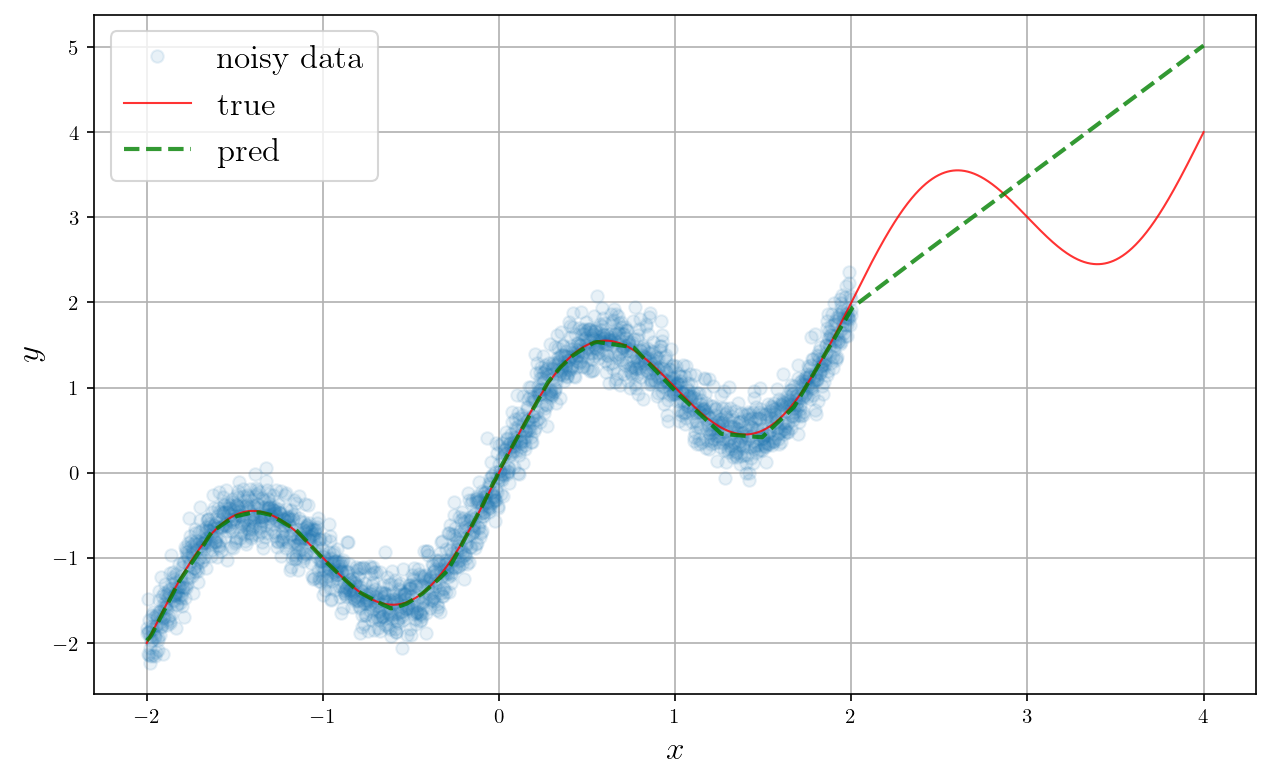

In [58]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x_in, y_in, 'o', label='noisy data', alpha=0.1)
plt.plot(x, y_true, 'r-', linewidth=1, label='true', alpha=0.8)
plt.plot(x, y_hat, 'g--', linewidth=2, label='pred', alpha=0.8)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.show()

In [59]:
ds_autoreg = AutoRegData(*restore_from_noisy(x_in, best_model))

In [60]:
X_in = ds_autoreg.X
X_in.shape

torch.Size([1989, 10, 2])

In [65]:
y_pred_in = best_model2(X_in).detach().cpu().numpy()
y_pred_in.shape

(1989, 2)

In [66]:
x_plot = x_in[10:-1].reshape((-1,))
x_plot.shape

torch.Size([1989])

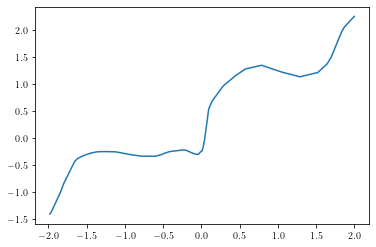

In [67]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x, y_true, 'r-', linewidth=1, label='true', alpha=0.8)
plt.plot(x, y_hat, 'g--', linewidth=2, label='pred', alpha=0.8)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.show()